In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.preprocessing import normalize
from scipy import signal
import skimage
import tifffile as tiff
import os
import math
import json

# sub function and class

In [11]:
def cut_fish_img(img, background, mean, std, mask, size):
    if img.ndim == 3 and img.shape[-1] == 3:
        a = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        a = img
    a = cv2.absdiff(a, background)
    outer = a*mask
    outer = np.where(outer>(mean+std*10), 255, 0).astype('uint8')
    M = cv2.moments(outer)

    pos = (int(M["m01"] / M["m00"]), int(M["m10"] / M["m00"])) 

    return pos, cutting_img(img, pos, size)

def partial_img(img, size = 150):
    #find the center and cut the image
    M = cv2.moments(img)

    cX = int(M["m01"] / M["m00"])
    cY = int(M["m10"] / M["m00"])

    startX = cX - size
    endX = cX + size

    if startX<0:
        startX=0
    if endX>=img.shape[0]:
        endX=img.shape[0]-1

    startY = cY - size
    endY = cY + size
    if startY<0:
        startY=0
    if endY>=img.shape[1]:
        endY=img.shape[1]-1

    a = img.copy()[startX:endX,startY:endY,...]
    
    return a, (cX, cY)

def cutting_img(img, pos, size=150):
    cX, cY = pos
    Len = size*2+1
    
    pad_arr=[[0,Len],[0,Len]]
    
    if img.ndim == 2: #1channel
        ndim = 1
        temp = np.zeros((Len, Len), dtype=np.uint8)
    elif img.shape[2] == 1:
        ndim = 1
        temp = np.zeros((Len, Len, 1), dtype=np.uint8)
    elif img.shape[2] == 3:
        ndim = 3
        temp = np.zeros((Len, Len, 3), dtype=np.uint8)
    else:
        raise Exception("wrong channel number!", img.shape)
    
    startX = cX - size
    endX = cX + size + 1
    
    if startX<0:
        pad_arr[0][0] = 0-startX
        startX=0
    if endX>img.shape[0]:
        pad_arr[0][1] = -endX+img.shape[0]
        endX=img.shape[0]
        
        
    startY = cY - size
    endY = cY + size + 1

    if startY<0:
        pad_arr[1][0] = 0-startY
        startY=0
    if endY>img.shape[1]:
        pad_arr[1][1] = -endY+img.shape[1]
        endY=img.shape[1]
    
    temp[pad_arr[0][0]:pad_arr[0][1], pad_arr[1][0]:pad_arr[1][1], ...]= img[startX:endX, startY:endY, ...]
    return temp

def mean_generater(imgs, background, mask, ch=3):
    
    outer = []
    if ch == 3:
        for img in imgs:
            a = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            a = cv2.absdiff(a, background)
            outer.append(a*mask)
    else:
        for img in imgs:
            a = cv2.absdiff(a, background)
            outer.append(a*mask)
        
    outer = np.array(outer)
    
    return np.mean(outer), np.std(outer)

"""class compress_tiff:
    
    def __init__(self, path, savepath=None, name=None):

                    
        if name is None:
            self.name = "exp_compress"
        else:
            self.name = name
            
        if savepath is None:
            self.savepath = os.path.join(path, self.name)
        else:
            self.savepath = os.path.join(savepath, self.name)
        self.path = path
        
        flist = os.listdir(path)
        tiflist = []
        for filename in flist:
            if os.path.isdir(filename):
                continue
            if filename.split(".")[-1] == "tiff":
                tiflist.append(filename)

        #rint('There is a total of ',len(tiflist), 'images')
        #for srt in os.listdir(path):
        #flist.append(srt.split('_'))

        tiflist.sort(key = lambda x: int(x.split("_")[-1].split(".")[0]) )
        
        flist = []
        for filename in tiflist:
            flist.append(os.path.join(path, filename))
        
        self.flist = flist.copy()
        
        return 
    def compress(self):
            os.mkdir(self.savepath)
            self.back = BG_tiff(self.flist, 500)
            tiff.imwrite(os.path.join(self.savepath, "background.tiff", self.back.cbackground))
            
            background = self.back.background
            
            
    def gen_config(self):
        f = open(os.path.join(self.path, self.name+".conf", "w"))"""

class BG_tiff: 
    def __init__(self, imgslist, nbckgnd = 1000):
        
        
        timg = tiff.TiffFile(imgslist[0]).asarray()
        if timg.ndim == 2 or timg.shape[-1] == 1:
            self.mono = True
        else:
            self.mono = False
            
            
        if self.mono:
            img_shape = tiff.imread(imgslist[0]).shape[0:2]
            total = np.zeros(img_shape)
            for file in imgslist[0:nbckgnd]:
                b = tiff.TiffFile(file).asarray()
                total = total + b 
            self.background = (total/nbckgnd).astype('uint8')
            self.cbackground = self.background
            self.shape = img_shape
            
        else:
            img_shape = tiff.imread(imgslist[0]).shape[0:2]
            total = np.zeros(img_shape)
            ctotal = np.zeros((*img_shape,3))
            for file in imgslist[0:nbckgnd]:
                b = tiff.TiffFile(file).asarray()
                ctotal += b
                b = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
                total = total + b 
            self.cbackground = (ctotal/nbckgnd).astype('uint8')
            self.background = (total/nbckgnd).astype('uint8')
            self.shape = img_shape
        
        back_itr = np.zeros(self.shape, dtype='uint8')
        back_itr = cv2.normalize(self.background.copy(), back_itr, 0, 255,  norm_type = cv2.NORM_MINMAX)   
   
        R=self.shape[0]
        pos = [0]*4
        R_L = [0]*4
        cir_num = 0
        while True:
            try:
                pos[cir_num], R_L[cir_num] = self.findcir(back_itr, R-20)
            except:
                break
            R = R_L[cir_num]

            mask = np.zeros(back_itr.shape, dtype = 'uint8')
            mask = cv2.circle(mask, pos[cir_num], R_L[cir_num]-2, 255, -1)>100

            back_itr = back_itr*mask
            back_itr = cv2.normalize(back_itr, back_itr, 0, 255,  norm_type = cv2.NORM_MINMAX)
            
            cir_num+=1
            
        self.cir_num = cir_num
        self.R_L = R_L
        self.pos = pos
        
    def findcir(self, img, maxR):
        circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1.2, 100, maxRadius = maxR)
        circles = np.round(circles[0, :]).astype("int")
        # loop over the (x, y) coordinates and radius of the circles
        for (x,y,r) in circles[:1]:
            pos = (x, y)
            MaxR = r

        return pos, MaxR
    
    def gen_mask(self,Rn, ch=1):
        
        if Rn >= self.cir_num:
            raise Exception("GG, too big")
            return
        
        if ch == 3:
            shape = (*(self.shape),3)
            black = (0,0,0)
            white = (255,255,255)
        elif ch == 1:
            shape = self.shape
            black = (0)
            white = 255
            
        if Rn == 0:
            mask = np.full(shape, 255, dtype = 'uint8')
            mask = cv2.circle(mask, self.pos[0], self.R_L[0], black, -1)
            mask = mask>100
        
        else:
            mask = np.zeros(shape, dtype = 'uint8')
            cv2.circle(mask, self.pos[Rn-1], self.R_L[Rn-1], white, -1)
            cv2.circle(mask, self.pos[Rn], self.R_L[Rn], black, -1)
            mask = mask>100
            
        return mask
    
def glue_img(img, pos, back, ch=3):
    
    if not img.shape[0] == img.shape[1]:
        raise Exception("the img is not square!")
    
    size = int((img.shape[0]-1)/2)
    shape = back.shape[0:2]
    
    background = back.copy()
    
    startX = pos[0] - size
    endX = pos[0] + size + 1
    redsX, redeX = 0, int(2*size)+1
    
    if startX <= 0:
        redsX = -startX
        startX = 0
    
    if endX >= shape[0]:
        redeX = endX - shape[0]
        redeX = 2*size - redeX +1
        endX = shape[0]
    
    startY = pos[1] - size
    endY = pos[1] + size + 1
    redsY, redeY = 0, int(2*size)+1
    
    if startY <= 0:
        redsY = -startY
        startY = 0
    
    if endY >= shape[1]:
        redeY = endY - shape[1]
        redeY = 2*size - redeY +1
        endY = shape[1]
    
    #print(pos, (startY,endY), (redsY, redeY))
    
    background[startX:endX, startY:endY, ...] = img[redsX:redeX, redsY:redeY, ...]
    return background

def optimizer(imgs, background, inner_mask, outer_mask, size=100, op_lost = 3):
    
    start = time.time()
    outer_mean, outer_std = mean_generater(imgs, background, outer_mask)
    inner_mean, inner_std = mean_generater(imgs, background, inner_mask)
    #print((outer_mean, outer_std),(inner_mean, inner_std))
    
    gimgs = []
    
    if imgs[0].ndim == 3 and imgs.shape[-1] == 3:
        for img in imgs:
            gimgs.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        
    N = len(gimgs)
    is_pass = False
    op_size = size
        
    for s in range(10):
        lost = 0
        for img in gimgs:
        
            ori_num = 0
            a = cv2.absdiff(img, background)

            outer = a*outer_mask
            outer = outer>(outer_mean+outer_std*10)
            M = cv2.moments(np.where(outer, 255, 0).astype('uint8'))
            pos = (int(M["m01"] / M["m00"]), int(M["m10"] / M["m00"]))
            ori_num += np.sum(outer*1)
            
            cimg = cutting_img(img, pos, size)
            com_img = glue_img(cimg, pos, background)
            
            inner = a*inner_mask
            inner = inner>(inner_mean+inner_std*10)
            M = cv2.moments(np.where(inner, 255, 0).astype('uint8'))
            pos = (int(M["m01"] / M["m00"]), int(M["m10"] / M["m00"])) 
            ori_num += np.sum(inner*1)
            
            cimg = cutting_img(img, pos, size)
            com_img = glue_img(cimg, pos, com_img)
        
        
            com_num = 0
            
            a = cv2.absdiff(com_img, background)
            outer = a*outer_mask
            outer = outer>(outer_mean+outer_std*10)
            com_num += np.sum(outer*1)
            
            inner = a*inner_mask
            inner = inner>(inner_mean+inner_std*10)
            com_num += np.sum(inner*1)
            
            lost += ori_num - com_num
        
        lost = lost/N
        
        if lost < op_lost :
            is_pass = True
            op_size = size
            size = size*0.8
        
        if not is_pass:
            size = size*2
        
        elif lost > op_lost :
            size *= 1.1
        
        size = int(size)
        
    print("op_time : ", time.time()-start)
    
    return op_size+10
        

# load image path and sort

In [12]:
#指定路徑(絕對路徑)
path = "/home/isis0517/Documents/data/compress/1.m2w2-10nit-1.8cm/"
savepath = "/home/isis0517/Documents/data/compress/1.m2w2-10nit-1.8cm_com"

if not os.path.isdir(savepath):
    os.mkdir(savepath)

if not os.path.isdir(os.path.join(savepath, "pos1")):
    os.mkdir(os.path.join(savepath, "pos1"))
if not os.path.isdir(os.path.join(savepath, "pos2")):
    os.mkdir(os.path.join(savepath, "pos2"))
    
flist = os.listdir(path)
tiflist = []
for filename in flist:
    if os.path.isdir(filename):
        continue
    if filename.split(".")[-1] == "tiff":
        tiflist.append(filename)

print('There is a total of ',len(tiflist), 'images')
frame_num = len(tiflist)
#for srt in os.listdir(path):
#flist.append(srt.split('_'))

#排序路徑
tiflist.sort(key = lambda x: int(x.split("_")[-1].split(".")[0]))

#變成絕對路徑
flist = []
for filename in tiflist:
    flist.append(os.path.join(path, filename))

There is a total of  16833 images


# generate background

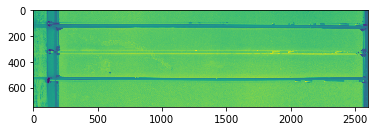

In [13]:
tnum = np.random.randint(len(flist),size=1000)
tlist=[]
for s in tnum:
    tlist.append(flist[s])

back = BG_tiff(tlist)
plt.imshow(back.cbackground)
plt.show()
tiff.imwrite(os.path.join(savepath, "background.tiff"), back.cbackground)
background = back.background

# generate mask

In [ ]:
outer_mask = back.gen_mask(0)
inner_mask = back.gen_mask(2)

# cutting the image and save

In [ ]:
tnum = np.random.randint(len(flist),size=1000)
tlist=[]
for s in tnum:
    tlist.append(flist[s])
    
test = tiff.TiffSequence(tlist).asarray()

outer_mean, outer_std = mean_generater(test, background, outer_mask)
inner_mean, inner_std = mean_generater(test, background, inner_mask)


# size 決定要切成多大
size = optimizer(test, back.background, inner_mask, outer_mask)
# 每次迴圈處理幾個image(一次讀入的數量，注意記憶體大小)
group_len = 1000

print("op_size : ", size)
#flist = flist[0:5000]

In [ ]:
pos1 = []
pos2 = []
video = cv2.VideoWriter(os.path.join(savepath, "video.avi"), cv2.VideoWriter_fourcc(*'XVID'), 
                        20, (background.shape[0]//3,background.shape[1]//3))
#video2 = cv2.VideoWriter(os.path.join(savepath, "video2.avi"), cv2.VideoWriter_fourcc(*'ASLC'), 30, (size*2+1,size*2+1))

start = time.time()
num = 0

for s in range(len(flist)//group_len):
    
    imgs = tiff.TiffSequence(flist[s*group_len:(s+1)*group_len]).asarray()
    
    read_time = time.time()
    
    for img in imgs:
                
        pos, cimg = cut_fish_img(img, background, outer_mean, outer_std, outer_mask, size)
        pos1.append(pos)
        tiff.imwrite(os.path.join(savepath,"pos1","frame_"+str(num)+".tiff"),cimg)
        
        pos, cimg = cut_fish_img(img, background, inner_mean, inner_std, inner_mask, size)
        pos2.append(pos)
        tiff.imwrite(os.path.join(savepath,"pos2","frame_"+str(num)+".tiff"),cimg)
        num += 1
        
        video.write(cv2.resize(src=img,dsize=(int(img.shape[1] // 3),int(img.shape[0] // 3))))
        
    print((s+1)*group_len, "read time", read_time-start, "write time", time.time()-read_time)
    start = time.time()
        
for filename in flist[(len(flist)//group_len)*group_len:]:
    
    img = tiff.TiffFile(filename).asarray()
    
    pos, cimg = cut_fish_img(img, background, outer_mean, outer_std, outer_mask, size)
    pos1.append(pos)
    tiff.imwrite(os.path.join(savepath,"pos1","frame_"+str(num)+".tiff"),cimg)
    
    pos, cimg = cut_fish_img(img, background, inner_mean, inner_std, inner_mask, size)
    pos2.append(pos)
    tiff.imwrite(os.path.join(savepath,"pos2","frame_"+str(num)+".tiff"),cimg)
    num += 1
    
    video.write(cv2.resize(src=img,dsize=(int(img.shape[1] // 3),int(img.shape[0] // 3))))
"""
for filename in tiflist:
    a = tiff.TiffFile(path+filename).asarray()
    Cimg = a.copy()
    a = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
    a = cv2.absdiff(a, background)
    in_fish = a*outer_mask
    in_fish = np.where(in_fish>(mean+std*15), 255, 0).astype('uint8')
    _, pos = partial_img(in_fish)
    pos1.append(pos)
    video1.write(cutting_img(Cimg, pos, size))
"""
video.release()
#video2.release()

np.save(os.path.join(savepath, "pos1.npy"), pos1)
np.save(os.path.join(savepath, "pos2.npy"), pos2)

config = {"size": size, "frame_num":frame_num, "version" : "alpha",
          "date": time.strftime("%Y-%m-%d %H:%M", time.localtime()), "shape":background.shape}

with open(os.path.join(savepath, "save.config"), 'w') as jsonfile:
    json.dump(config, jsonfile, indent=4)



# test for size optimizer

In [ ]:
def optimizer(imgs, background, inner_mask, outer_mask, size=100, op_lost = 1.6):
    
    start = time.time()
    outer_mean, outer_std = mean_generater(imgs, background, outer_mask)
    inner_mean, inner_std = mean_generater(imgs, background, inner_mask)
    #print((outer_mean, outer_std),(inner_mean, inner_std))
    
    gimgs = []
    
    for img in imgs:
        gimgs.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        
    N = len(gimgs)
    is_pass = False
    op_size = size
        
    for s in range(10):
        lost = 0
        for img in gimgs:
        
            ori_num = 0
            a = cv2.absdiff(img, background)

            outer = a*outer_mask
            outer = outer>(outer_mean+outer_std*10)
            M = cv2.moments(np.where(outer, 255, 0).astype('uint8'))
            pos = (int(M["m01"] / M["m00"]), int(M["m10"] / M["m00"]))
            ori_num += np.sum(outer*1)
            
            cimg = cutting_img(img, pos, size)
            com_img = glue_img(cimg, pos, background)
            
            inner = a*inner_mask
            inner = inner>(inner_mean+inner_std*10)
            M = cv2.moments(np.where(inner, 255, 0).astype('uint8'))
            pos = (int(M["m01"] / M["m00"]), int(M["m10"] / M["m00"])) 
            ori_num += np.sum(inner*1)
            
            cimg = cutting_img(img, pos, size)
            com_img = glue_img(cimg, pos, com_img)
        
        
            com_num = 0
            
            a = cv2.absdiff(com_img, background)
            outer = a*outer_mask
            outer = outer>(outer_mean+outer_std*10)
            com_num += np.sum(outer*1)
            
            inner = a*inner_mask
            inner = inner>(inner_mean+inner_std*10)
            com_num += np.sum(inner*1)
            
            lost += ori_num - com_num
        
        lost = lost/N
        
        if lost < op_lost :
            is_pass = True
            op_size = size
            size = size*0.8
        
        if not is_pass:
            size = size*2
        
        elif lost > op_lost :
            size *= 1.1
        
        size = int(size)
        
    print("op_time : ", time.time()-start)
    
    return op_size
        